# OpenFLASH Tutorial

Welcome to this tutorial on using OpenFLASH! This guide demonstrates how to set up a multi-body hydrodynamic problem, run the simulation engine, and analyze the results.

OpenFLASH uses the **Matched Eigenfunction Expansion Method (MEEM)** to efficiently analyze wave interactions with concentric structures, providing key hydrodynamic insights like added mass, damping, and potential fields.

---

## 1. Prerequisites and Setup

Before you begin, make sure you have installed the `openflash` package. If you haven't, you can install it using `pip`. It's highly recommended to do this within a virtual environment.

```bash
# Install the package from your local project directory
pip install open-flash
```

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

<class 'module'>
['/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash']
/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash/__init__.py
OpenFLASH modules imported successfully!


---

## 2. Defining the Problem Geometry

We'll start by defining the physical layout of our problem. The core idea is to create `SteppedBody` objects that represent the physical structures. For this example, we'll simulate **two concentric bodies**.

* **h**: Total water depth.
* **a\_list**: A list of outer radii for each physical body.
* **d\_list**: A list of submerged depths for each body's step.
* **heaving\_list**: A list of boolean flags (`True`/`False`) indicating if each body is heaving.
* **NMK**: The number of harmonics to use in the series expansion for each fluid domain (this will be `number of bodies + 1`).

In [2]:
# --- Simulation Parameters ---
h = 1.001            # Water Depth (m)
d_list = [0.5, 0.25]   # Step depths (m) for inner and outer bodies
a_list = [0.5, 1.0]    # Radii (m) for inner and outer bodies
heaving_list = [True, False] # Heaving flags for each body

# Number of Harmonics (NMK) for inner, middle, and exterior domains
NMK = [30, 30, 30]

m0 = 1.0    # Non-dimensional wave number
problem_omega = omega(m0, h, g)
print(f"Wave number (m0): {m0}, Angular frequency (omega): {problem_omega:.4f}")

spatial_res = 75 # Spatial resolution for plotting grids

print("Simulation parameters defined.")

Wave number (m0): 1.0, Angular frequency (omega): 2.7341
Simulation parameters defined.


### Create Geometry and MEEM Problem Instances

Now, we use these parameters to build our geometry in a structured, object-oriented way.

In [3]:
# Number of radial boundaries (cylinders)
boundary_count = len(NMK) - 1

# Construct Domain Parameters for Geometry (as done in app.py)

# 1. Create a list of SteppedBody objects
bodies = []
for i in range(len(a_list)):
    body = SteppedBody(
        a=np.array([a_list[i]]),
        d=np.array([d_list[i]]),
        slant_angle=np.array([0.0]), # Assuming flat tops
        heaving=heaving_list[i]
    )
    bodies.append(body)

# 2. Group the bodies into an arrangement
arrangement = ConcentricBodyGroup(bodies)

# 3. Create a concrete Geometry instance
geometry = BasicRegionGeometry(
    body_arrangement=arrangement,
    h=h,
    NMK=NMK
)

# 4. Create the MEEMProblem instance
problem = MEEMProblem(geometry)

# 5. Set the frequencies and modes for the problem
problem_frequencies = np.array([problem_omega])
# FIX: Determine modes based on which bodies are set to heave
problem_modes = np.where(heaving_list)[0]
problem.set_frequencies_modes(problem_frequencies, problem_modes)

print("Geometry and MEEM Problem initialized using the modern object-oriented API.")
print(f"Problem configured with {len(problem.frequencies)} frequency(ies) and {len(problem.modes)} mode(s): {problem_modes}.")

Geometry and MEEM Problem initialized using the modern object-oriented API.
Problem configured with 1 frequency(ies) and 1 mode(s): [0].


---

## 3. Running the MEEM Engine

The `MEEMEngine` orchestrates the entire simulation. We initialize it with our problem and call the appropriate methods to solve the system. For a single frequency, we use `solve_linear_system_multi`.

In [4]:
# Initialize the MEEM Engine with the problem
engine = MEEMEngine(problem_list=[problem])
engine._ensure_m_k_and_N_k_arrays(problem,m0)

# Assemble the system matrix A and right-hand side vector b
# These methods internally use the ProblemCache for efficiency
A = engine.assemble_A_multi(problem, m0)
b = engine.assemble_b_multi(problem, m0)

print(f"System matrix A assembled. Shape: {A.shape}")
print(f"Right-hand side vector b assembled. Shape: {b.shape}")

# Solve the linear system A * X = b for X
X = engine.solve_linear_system_multi(problem, m0)

print(f"Linear system solved. Solution vector X shape: {X.shape}")

# Reformat coefficients into a more usable structure (Cs list of arrays)
Cs = engine.reformat_coeffs(X, NMK, boundary_count)
print(f"Coefficients reformatted into {len(Cs)} regions.")
for i, c_region in enumerate(Cs):
    print(f"  Region {i} (NMK={NMK[i]}): {c_region.shape} coefficients")

System matrix A assembled. Shape: (120, 120)
Right-hand side vector b assembled. Shape: (120,)
Linear system solved. Solution vector X shape: (120,)
Coefficients reformatted into 3 regions.
  Region 0 (NMK=30): (30,) coefficients
  Region 1 (NMK=30): (60,) coefficients
  Region 2 (NMK=30): (30,) coefficients


/Users/hopebest/Documents/semi-analytical-hydro/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.46955e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


---

## 4. Analyzing and Visualizing Results

With the solution vector `X`, we can now compute and visualize the physical results. 

### Hydrodynamic Coefficients

The engine can compute the added mass and damping coefficient matrices from the solution vector.

In [ ]:
hydro_coefficients = engine.compute_hydrodynamic_coefficients(problem, X, m0)

if hydro_coefficients:
    # The result is a list of dictionaries, one for each interaction (mode_i, mode_j)
    # We can format this into a more readable table
    df_coeffs = pd.DataFrame(hydro_coefficients)
    print("\nCalculated Hydrodynamic Coefficients:")
    print(df_coeffs)
else:
    print("Hydrodynamic coefficients could not be calculated.")



Calculated Hydrodynamic Coefficients:
   Mode Index  Added Mass (Real)  Damping (Imaginary)
0           0         288.978396           189.013785
1           1         595.741621           592.674309


### Potential Field Visualization 

Next, we'll calculate the potential field over a 2D spatial grid and visualize it.


Coefficients reformatted into 3 regions.
  Region 0 (NMK=30): (30,) coefficients
  Region 1 (NMK=30): (60,) coefficients
  Region 2 (NMK=30): (30,) coefficients


/Users/hopebest/Documents/semi-analytical-hydro/package/src/openflash/multi_equations.py:347: RuntimeWarning: invalid value encountered in divide
  bessel_term = (besselke(0, lambda_val * r) / denom) * exp(lambda_val * (scale(a)[i] - r))


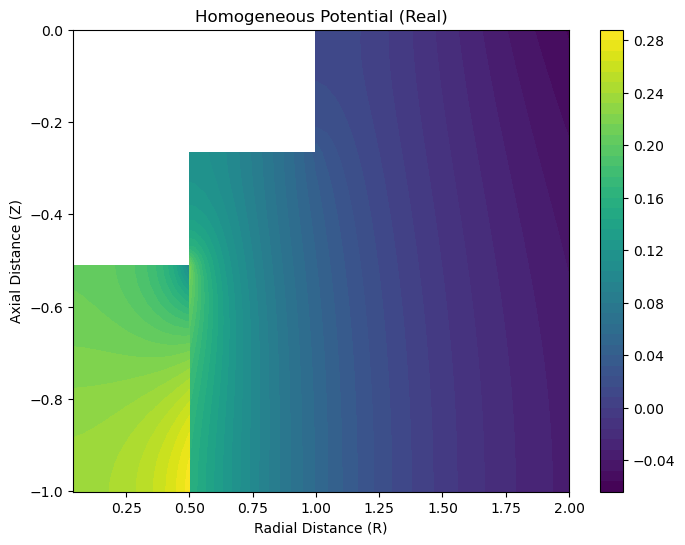

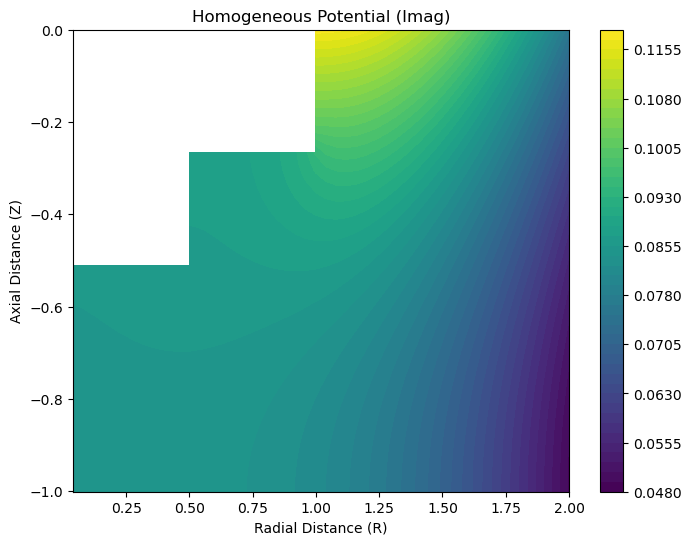

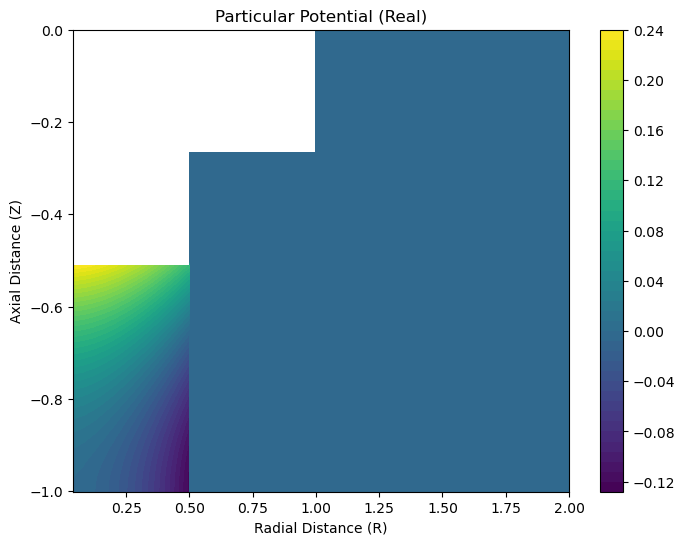

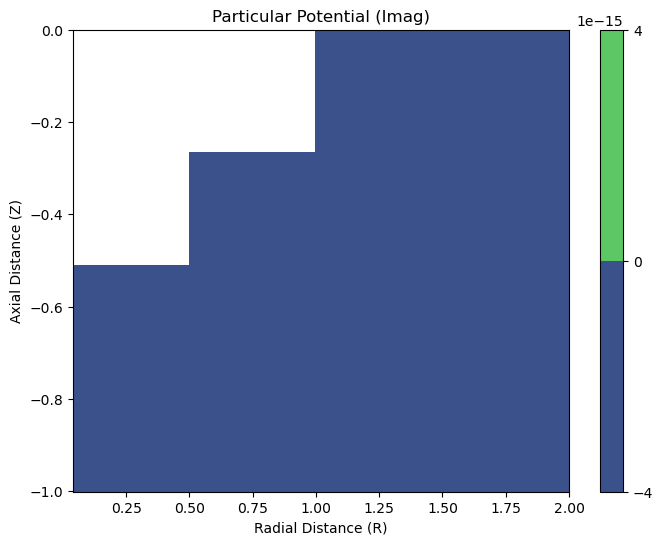

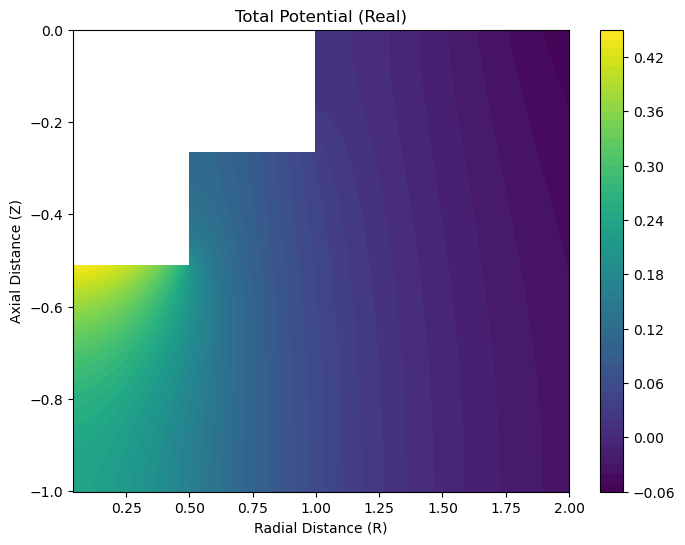

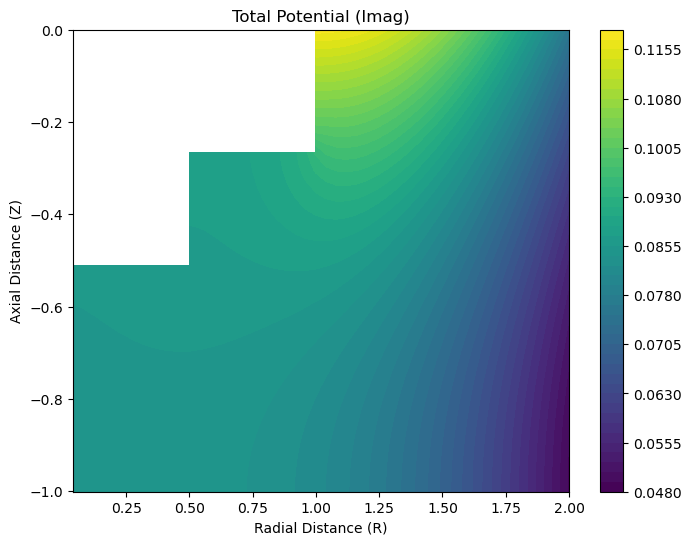

In [ ]:
# --- Reformat coefficients using the dedicated MEEMEngine method ---
reformat_boundary_count = len(NMK) - 1
Cs = engine.reformat_coeffs(X, NMK, reformat_boundary_count)
print(f"\nCoefficients reformatted into {len(Cs)} regions.")
for i, c_region in enumerate(Cs):
    print(f"  Region {i} (NMK={NMK[i]}): {c_region.shape} coefficients")
        
# --- Use MEEMEngine to calculate potentials ---
potentials = engine.calculate_potentials(problem, X, m0, spatial_res=50, sharp=True)

# Unpack
R = potentials["R"]
Z = potentials["Z"]
phiH = potentials["phiH"]
phiP = potentials["phiP"]
phi = potentials["phi"]

# --- Plot using built-in visualizer ---
engine.visualize_potential(np.real(phiH), R, Z, "Homogeneous Potential (Real)")
engine.visualize_potential(np.imag(phiH), R, Z, "Homogeneous Potential (Imag)")
engine.visualize_potential(np.real(phiP), R, Z, "Particular Potential (Real)")
engine.visualize_potential(np.imag(phiP), R, Z, "Particular Potential (Imag)")
engine.visualize_potential(np.real(phi), R, Z, "Total Potential (Real)")
engine.visualize_potential(np.imag(phi), R, Z, "Total Potential (Imag)")
        
plt.show()

## 5. Saving Results to NetCDF

The `Results` class is used to store all simulation ou `xarray.Dataset` and export them to a file. This is especially useful after running a frequency sweep.

In [ ]:
results_obj = Results(geometry, problem_frequencies, problem_modes)

# --- FIX: Store hydrodynamic coefficients with the correct 3D shape ---
num_frequencies = len(problem_frequencies)
num_modes = len(problem_modes)

# Reshape the flat list of coefficient dictionaries into 3D numpy arrays
added_mass_matrix = np.array([hc['real'] for hc in hydro_coefficients]).reshape(num_frequencies, num_modes, num_modes)
damping_matrix = np.array([hc['imag'] for hc in hydro_coefficients]).reshape(num_frequencies, num_modes, num_modes)

results_obj.store_hydrodynamic_coefficients(
    problem_frequencies, problem_modes, added_mass_matrix, damping_matrix
)
print("\nHydrodynamic coefficients stored in the Results object.")

print("problem_frequencies:", problem_frequencies)
print("problem_modes:", problem_modes)
print("added_mass_matrix shape:", added_mass_matrix.shape)
print("damping_matrix shape:", damping_matrix.shape)

# --- FIX: Store the calculated spatial potential field directly in the dataset ---
# The Results class doesn't have a dedicated method for this, but we can add it
# directly to the underlying xarray Dataset.
if "phi" in potentials:
    # Store the complex data as separate real and imaginary parts for NetCDF compatibility
    results_obj.dataset['potential_field_real'] = (('z', 'r'), np.real(potentials['phi']))
    results_obj.dataset['potential_field_imag'] = (('z', 'r'), np.imag(potentials['phi']))
    # Also store the coordinate grids
    results_obj.dataset.coords['r'] = potentials['R'][0, :]
    results_obj.dataset.coords['z'] = potentials['Z'][:, 0]
    print("Spatial potential field data stored in the Results object.")

# Export the entire dataset to a NetCDF file
file_path = "meem_simulation_results.nc"
results_obj.export_to_netcdf(file_path)
print(f"All results successfully saved to '{file_path}'")

# You can also inspect the final xarray Dataset
print("\nContents of the final xarray Dataset:")
print(results_obj.get_results())

problem_frequencies: [2.73410963]
problem_modes: [0 1]
added_mass_matrix shape: (1, 2)
damping_matrix shape: (1, 2)
Hydrodynamic coefficients stored in xarray dataset.
Stored single potential field for mode 0 and frequency 0.
Results successfully exported to meem_simulation_results.nc (h5netcdf format).
Results saved to meem_simulation_results.nc

Contents of the xarray Dataset:
<xarray.Dataset> Size: 90kB
Dimensions:                 (frequencies: 1, modes: 2, z_coord: 52, r_coord: 54)
Coordinates:
  * frequencies             (frequencies) float64 8B 2.734
  * modes                   (modes) int64 16B 0 1
Dimensions without coordinates: z_coord, r_coord
Data variables:
    added_mass              (frequencies, modes) float64 16B 289.0 595.7
    damping                 (frequencies, modes) float64 16B 189.0 592.7
    potential_R_0_0         (z_coord, r_coord) float64 22kB 0.04 0.08 ... 2.0
    potential_Z_0_0         (z_coord, r_coord) float64 22kB -1.001 ... 0.0
    potential_phi_real_

## 6. Conclusion

This tutorial has walked you through the modern, object-oriented workflow for running a simulation with OpenFLASH. You've learned how to:

* Define a physical problem using `SteppedBody` objects.
* Initialize and execute the `MEEMEngine` to solve for the system's coefficients.
* Extract and view hyrdodynamic coefficients.
* Calculate and visualzie the spatial potential field.
* Store all simulation results in a structured `Results` object and export to NetCDF.

For more detailed information on specific classes and functions, please refer to the project's Sphinx documentation.

Feel free to experiment with different parameters and geometries to explore various hydrodynamic scenarios!